In [1]:
from pikan.model_utils import GeneralizedMLP, FourierKAN, PirateNet
from pikan.model_utils import get_mse_loss
from pikan.model_utils import KeyHandler, sobol_sample
from pikan.utils import load_dict_from_file, save_dict_to_file

from pikan.interpolated_funcs import circular_wave_interference

import yaml
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
from functools import partial
from tqdm import tqdm
import pandas as pd

import jax
import pickle
import os

import matplotlib.pyplot as plt

from pikan.pde_utils import get_pde_Helmholtz, get_pde_heat1, get_pde_burgers1
from pikan.pde_utils import get_vanilla_loss, get_adaptive_loss, get_pde_train_step
jax.devices()

[CpuDevice(id=0)]

In [2]:
def sample_collocs(config):
    collocs = jnp.array(sobol_sample(np.array([config["X_MIN"],config["Y_MIN"]]), 
                                     np.array([config["X_MAX"],config["Y_MAX"]]), config["BS"]))
    return collocs

def get_model(config):
    if config["MODEL"] == "MLP":
        return GeneralizedMLP(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "KAN":
        return FourierKAN(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "PIRATE":
        return PirateNet(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            layer_sizes=config['layers'] # first is fourier
        )


def sum_params(data, verbose=False):
    total = 0
    if isinstance(data, type(jnp.array([]))):  # If the current node is a leaf array
        return len(data.reshape(-1))
    elif isinstance(data, dict):  # If the current node is a dictionary
        for key, value in data.items():
            if verbose:
                print(f"Processing key: {key}")  # Print the current key
            branch_total = sum_params(value)  # Compute the total for this subbranch
            if verbose:
                print(f"Total parameters in subbranch '{key}': {branch_total}")
            total += branch_total
    
    return total

In [3]:
# filename = "SWEEP_HelmHoltz"
# filename = "SWEEP_HeatEq1"
filename = "SWEEP_Burger1"

with open(f"yaml_configs/PDE_configs/{filename}.yaml", 'r') as file:
    config = yaml.safe_load(file)

keygen = KeyHandler(0)
config["experiments"].keys()

select = 1
for idx, exp_key in enumerate(config["experiments"].keys()):
    print(exp_key)
    if idx == select:
        experiment = config["experiments"][exp_key]

experiment

burger_1
burger_2


{'BS': 32768,
 'BS_BC': 2048,
 'EPOCHS': 10000,
 'EQUATION': 'burgers_eq1',
 'FourierFeatures': True,
 'MODEL': 'MLP',
 'layers': [64, 64, 64],
 'N_INPUT': 2,
 'X_MIN': -1,
 'X_MAX': 1,
 'Y_MIN': 0,
 'Y_MAX': 1}

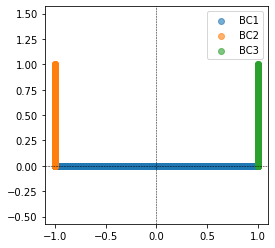

In [4]:
def plot_bc_collocs(bc_collocs):
    """Plots the boundary collocation points."""
    plt.figure(figsize=(4, 4))
    for i, colloc in enumerate(bc_collocs, start=1):
        plt.scatter(colloc[:, 0], colloc[:, 1], label=f'BC{i}', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend()
    plt.axis('equal')
    plt.show()

def get_helmholtz_boundaries(experiment):
    # only sample boundary once
    BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), experiment["BS_BC"]))
    BC1_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), experiment["BS_BC"]))
    BC2_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), experiment["BS_BC"]))
    BC3_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), experiment["BS_BC"]))
    BC4_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
    bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]
    return bc_collocs, bc_data

def get_heat_boundaries(experiment):
    # t=0
    BC1_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([1,0]), experiment["BS_BC"]))
    BC1_data = jnp.sin(jnp.pi * BC1_colloc[:, 0]).reshape(-1,1)
    
    BC2_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([0,1]), experiment["BS_BC"]))
    BC2_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    BC3_colloc = jnp.array(sobol_sample(np.array([1,0]), np.array([1,1]), experiment["BS_BC"]))
    BC3_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
    bc_data = [BC1_data, BC2_data, BC3_data]
    
    return bc_collocs, bc_data


def get_burgers_boundaries(experiment):
    # t=0
    BC1_colloc = jnp.array(sobol_sample(np.array([-1,0]), np.array([1,0]), experiment["BS_BC"]))
    BC1_data = -jnp.sin(jnp.pi * BC1_colloc[:, 0]).reshape(-1,1)
    
    BC2_colloc = jnp.array(sobol_sample(np.array([-1,0]), np.array([-1,1]), experiment["BS_BC"]))
    BC2_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    BC3_colloc = jnp.array(sobol_sample(np.array([1,0]), np.array([1,1]), experiment["BS_BC"]))
    BC3_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)
    
    bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
    bc_data = [BC1_data, BC2_data, BC3_data]
    
    return bc_collocs, bc_data
    
if experiment["EQUATION"] == "helmholtz":
    bc_collocs, bc_data = get_helmholtz_boundaries(experiment)
if experiment["EQUATION"] == "heat_eq1":
    bc_collocs, bc_data = get_heat_boundaries(experiment)
if experiment["EQUATION"] == "burgers_eq1":
    bc_collocs, bc_data = get_burgers_boundaries(experiment)
    
plot_bc_collocs(bc_collocs)

In [5]:
bc_collocs[0][:, 0].min()

Array(-0.9994722, dtype=float32)

In [6]:
collocs = sample_collocs(experiment)

N_collocs = collocs.shape[0] + len(bc_collocs) * bc_collocs[0].shape[0]
loc_w = [jnp.ones((collocs.shape[0], 1))] + [jnp.ones((bc_collocs[0].shape[0], 1)) for i in range(len(bc_collocs))]
len(loc_w) # attention weights for collocs and bc are independent

4

In [7]:
model = get_model(experiment)

variables = model.init(keygen.key(), collocs)

# Define a cosine decay learning rate schedule
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=experiment["EPOCHS"],  # Total number of decay steps
    alpha=1e-3             # Final learning rate multiplier
)

optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
opt_state = optimizer.init(variables['params'])

if experiment["EQUATION"] == "helmholtz":
    pde_loss = get_pde_Helmholtz(model, modeltype=experiment["MODEL"])
if experiment["EQUATION"] == "heat_eq1":
    pde_loss = get_pde_heat1(model, modeltype=experiment["MODEL"])
if experiment["EQUATION"] == "burgers_eq1":
    pde_loss = get_pde_burgers1(model, modeltype=experiment["MODEL"])
    
loss_fn = get_adaptive_loss(model, pde_loss, modeltype=experiment["MODEL"])
train_step = get_pde_train_step(model, optimizer, loss_fn)

model, sum_params(variables["params"])

(GeneralizedMLP(
     # attributes
     kernel_init = init
     num_input = 2
     num_output = 1
     use_fourier_feats = True
     layer_sizes = [64, 64, 64]
 ),
 8481)

In [8]:
%%time
grid_adaption = {}

# train always on same colloc points
collocs = sample_collocs(experiment)

if experiment["MODEL"] != "KAN":
        variables["state"] = []
    
losses = []
for i in (pbar:= tqdm(range(experiment["EPOCHS"]))):
    params, state = variables['params'], variables['state']
    params, opt_state, loss, loc_w = train_step(params, collocs, bc_collocs, 
                                                 bc_data, opt_state, state, loc_w)    
    variables = {'params': params, 'state':state}
    
    losses.append(loss)
    
    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")
        # 21.68it/s KAN

Loss  0.00192283:   9%|▊         | 855/10000 [04:17<45:57,  3.32it/s]


KeyboardInterrupt: 

Original shape: (256, 100)


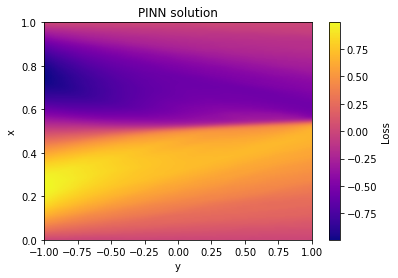

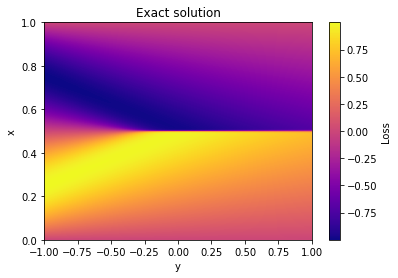

In [9]:
from scipy.ndimage import zoom

def load_analytical_burgers(Nx, Ny):
    data = np.load('Burgers.npz')
    usol = data['usol']

    print("Original shape:", usol.shape)
    # scaling_factors = (Nx / usol.shape[0], Ny / usol.shape[1])
    # usol = zoom(usol, scaling_factors)
    return usol
    
def plot_heatmap(arr, title, experiment):
    # Plot heatmap
    #plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(experiment["X_MIN"], experiment["X_MAX"], 
                            experiment["Y_MIN"], experiment["Y_MAX"]), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

def u(vec_x):
    y = model.apply(variables, vec_x)
    return y

def exact_u(vec_x, experiment, Nx, Ny):
    if experiment["EQUATION"] == "helmholtz":
        y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.sin(4*jnp.pi*vec_x[:, 1])
    if experiment["EQUATION"] == "heat_eq1":
        y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.exp(-vec_x[:, 1])
    if experiment["EQUATION"] == "burgers_eq1":
        y = load_analytical_burgers(Nx, Ny)
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

if experiment["MODEL"] != "KAN":
    variables = {'params': variables["params"]}

Nx = 256 # NxN grid
Ny = 100
x_grid = jnp.linspace(experiment["X_MIN"], experiment["X_MAX"], Nx)
y_grid = jnp.linspace(experiment["Y_MIN"], experiment["Y_MAX"], Ny)

# Create a meshgrid of x and t values
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing="ij")
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
coords = jnp.stack((x_flat, y_flat), axis=-1)

results = u(coords).reshape(Nx, Ny)
loss = pde_loss(params, coords, state).reshape(Nx, Ny)
exact = exact_u(coords, experiment, Nx, Ny).reshape(Nx,Ny)

plot_heatmap(results,"PINN solution", experiment)
plot_heatmap(exact,"Exact solution", experiment)

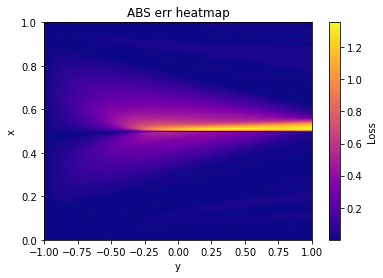

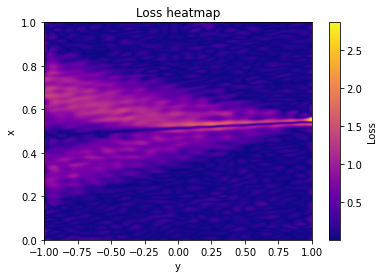

L2 error 35.4594%


Array(0.3545939, dtype=float32)

In [10]:
plot_heatmap(jnp.abs(results - exact),"ABS err heatmap", experiment)
plot_heatmap(jnp.abs(loss),"Loss heatmap", experiment)

l2_err = l2_error(results, exact)
print(f"L2 error {l2_err*100:.4f}%")
l2_err

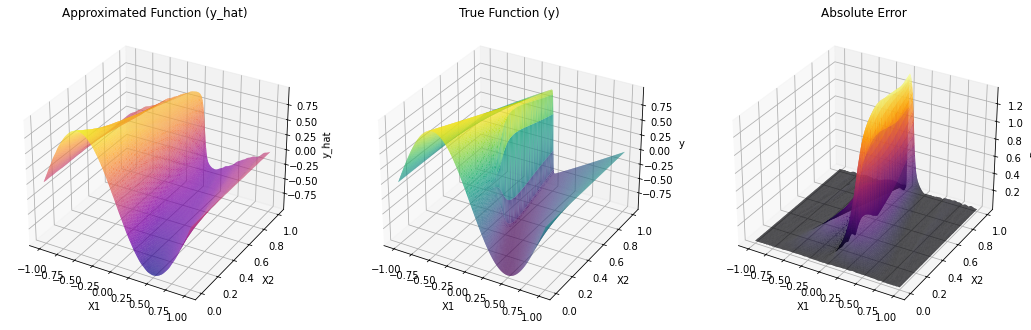

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from matplotlib import cm
import os

def compare_3d(coords, y_hat, y):
    # Compute the absolute error
    abs_error = jnp.abs(y - y_hat).reshape(-1, 1)

    # Create a figure and axis grid for the 3 subplots
    fig = plt.figure(figsize=(18, 6))

    # Plotting the approximated function (y_hat) on the left using the plasma colormap
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_trisurf(coords[:, 0], coords[:, 1], y_hat.flatten(), cmap=cm.plasma)
    ax1.set_title('Approximated Function (y_hat)')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('y_hat')

    # Plotting the true function (y) in the middle
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_trisurf(coords[:, 0], coords[:, 1], y.flatten(), cmap='viridis')
    ax2.set_title('True Function (y)')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('y')

    # Plotting the absolute error on the right
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_trisurf(coords[:, 0], coords[:, 1], abs_error.flatten(), cmap='inferno')
    ax3.set_title('Absolute Error')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('Error')

compare_3d(coords, results, exact)